# Time Series Week 11 - Assignment

## 1. Outlier Detection

### 1.1. Distribution-Based Methods

In [52]:
# Import the required modules: pandas, numpy, matplotlib
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Create a new dataset using pH and Dissolved_Oxygen_mg_L
DWLR_data = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/DWLR_Dataset.csv')
DWLR_data.head()

,Date,Water_Level_m,Temperature_C,Rainfall_mm,pH,Dissolved_Oxygen_mg_L
0,2023-01-01,2.124836,-0.601831,26.958453,6.948386,8.282231
1,2023-01-02,2.099955,0.396578,15.306932,6.952946,7.998230
2,2023-01-03,2.146121,0.139768,29.263846,6.912783,8.173989
3,2023-01-04,2.196756,0.327833,8.246142,6.972447,8.079537
4,2023-01-05,2.115765,-0.917756,35.654194,6.962424,8.425726


In [3]:
DWLR_data['Date'] = pd.to_datetime(DWLR_data['Date'])
ph_data = DWLR_data[['Date','pH']]
dissolved_oxygen_data = DWLR_data[['Date','Dissolved_Oxygen_mg_L']]

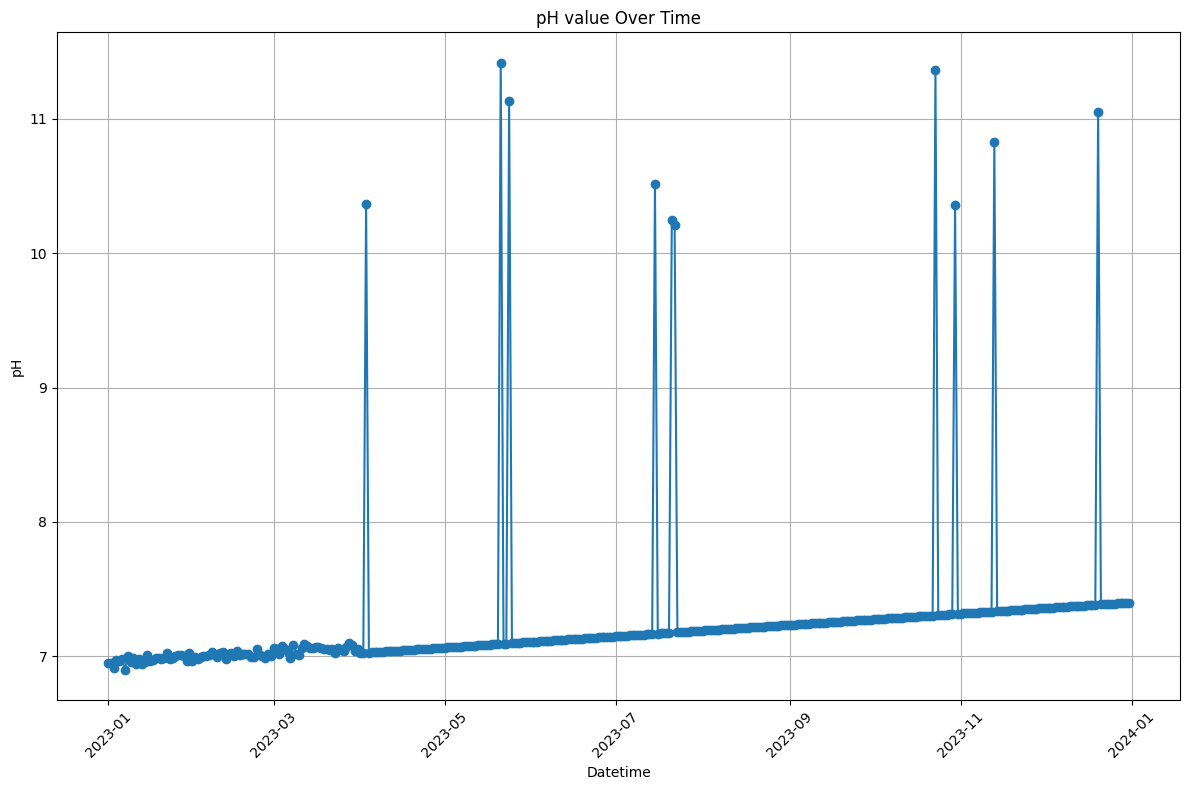

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(ph_data['Date'], ph_data['pH'], marker='o', linestyle='-')
plt.title('pH value Over Time')
plt.xlabel('Datetime')
plt.ylabel('pH')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Apply the Chauvenet criterion to detect water pH outliers in the time series data based on normal distribution assumptions. Plot the pH outliers with the original values.

In [5]:
# Define function which apply Chauvenet criterion to detect outlier

def chauvenet_criterion(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    N = len(data)

    # Calculate the Z-scores of each data point
    z_scores = np.abs(data - mean) / std_dev

    # Calculate the probability of each Z-score
    probabilities = 1 - stats.norm.cdf(z_scores)

    # Calculate the Chauvenet's criterion threshold
    criterion_threshold = 1.0 / (2 * N)

    # Identify outliers based on the criterion
    outliers = data[probabilities < criterion_threshold]
    return outliers

In [6]:
# Detect outlier with functionW
water_ph_data = DWLR_data['pH']
outliers = chauvenet_criterion(water_ph_data)
print("Outliers identified by Chauvenet's Criterion:", outliers)

outlier_indices = DWLR_data['pH'].isin(outliers)

Outliers identified by Chauvenet's Criterion: 92     10.362877
140    11.418093
143    11.134624
195    10.513126
201    10.243772
202    10.213754
295    11.362236
302    10.362299
316    10.827098
353    11.050327
Name: pH, dtype: float64


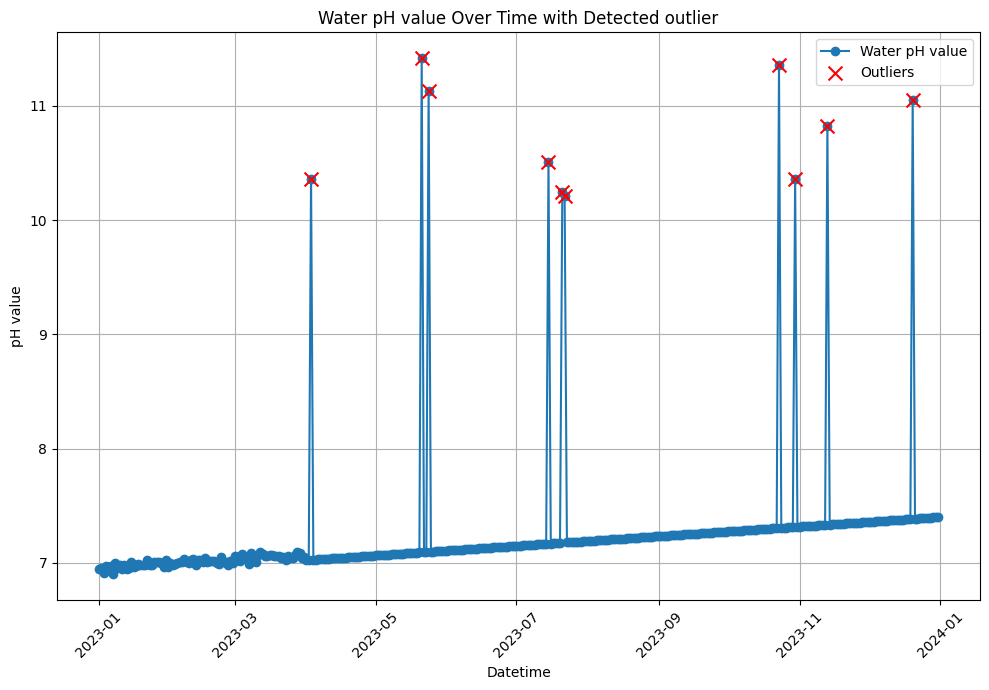

In [15]:
# Plot the pH outliers with the original values
plt.figure(figsize=(10, 7))
plt.plot(DWLR_data['Date'], DWLR_data['pH'], marker='o', linestyle='-', label='Water pH value')
plt.scatter(DWLR_data['Date'][outlier_indices], DWLR_data['pH'][outlier_indices], color='red', marker='x', s=100, label='Outliers', zorder=5)
plt.title('Water pH value Over Time with Detected outlier')
plt.xlabel('Datetime')
plt.ylabel('pH value')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

2.  Winsorize the pH data by capping extreme values (e.g., 5th and 95th percentiles) and visualize the effect on the time series. Plot the effect of Winsorization on Time Series Data of pH values.

In [16]:
from scipy.stats.mstats import winsorize

In [19]:
# Winsorize the pH data by capping extreme values (e.g., 5th and 95th percentiles) and visualize the effect on the time series
pH_rates = DWLR_data['pH'].values

# Apply Winsorizing to the pH data
winsorized_data = winsorize(pH_rates, limits=[0.05, 0.05])

# Add winsorized data as a column in the dataset
DWLR_data['winsorized_rate'] = winsorized_data

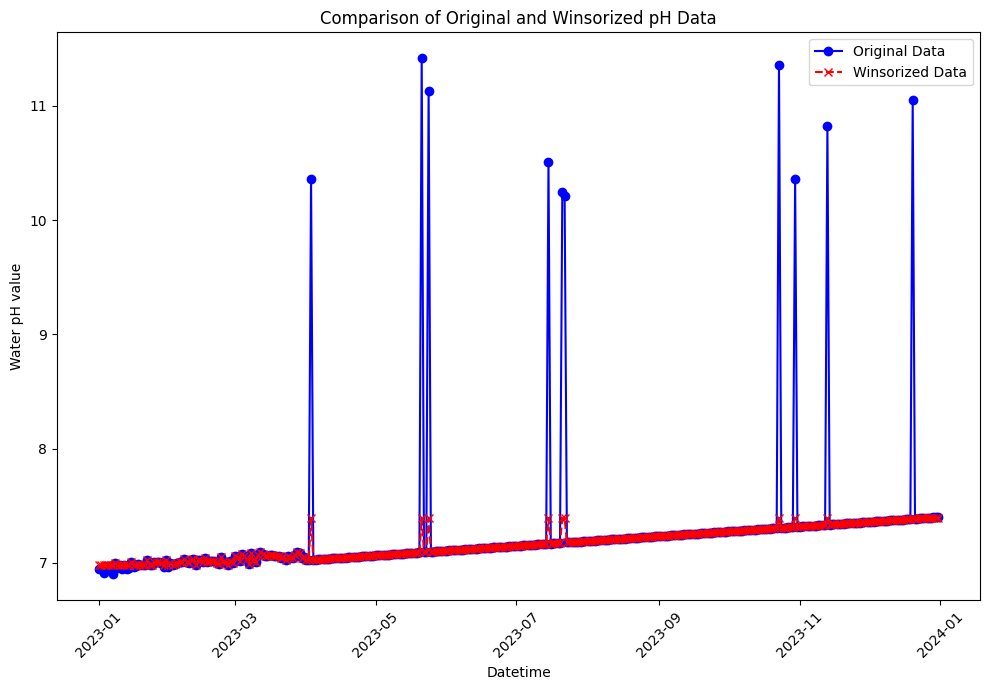

In [24]:
# Plot the effect of Winsorization on Time Series Data of pH values

plt.figure(figsize=(10, 7))
plt.plot(DWLR_data['Date'], DWLR_data['pH'], label='Original Data', color='b', linestyle='-', marker='o')
plt.plot(DWLR_data['Date'], DWLR_data['winsorized_rate'], label='Winsorized Data', color='r', linestyle='--', marker='x')
plt.title('Comparison of Original and Winsorized pH Data')
plt.xlabel('Datetime')
plt.ylabel('Water pH value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 1.2. Distance-Based Methods

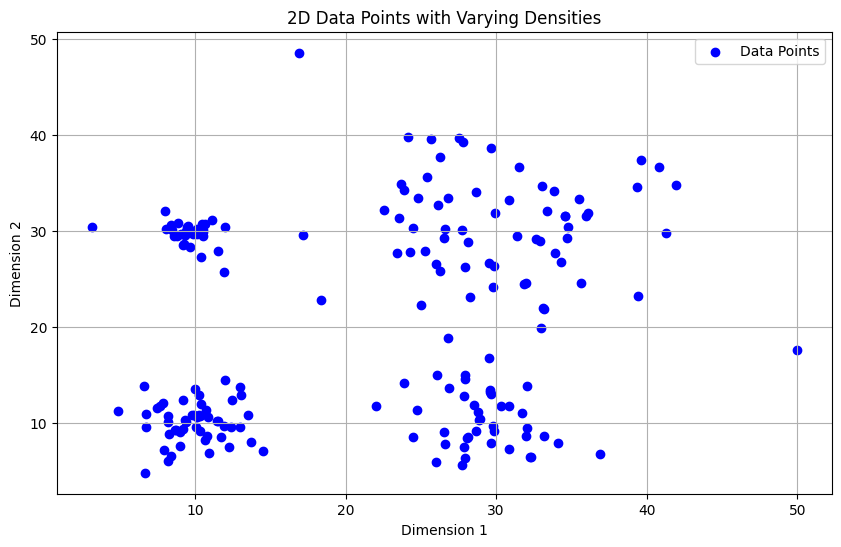

In [25]:
from sklearn.datasets import make_blobs

np.random.seed(0)

centers = [(10, 10), (30, 30), (10, 30), (30, 10)]
cluster_std = [2, 5, 1, 3]

X, _ = make_blobs(n_samples=[50, 60, 30, 40], centers=centers, cluster_std=cluster_std)

outliers = np.random.uniform(low=0, high=50, size=(10, 2))
data = np.vstack([X, outliers])

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points')
# plt.scatter(outliers[:, 0], outliers[:, 1], color='red', marker='x', s=100, label='Outliers')
plt.title('2D Data Points with Varying Densities')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

3. Define a function and detect outliers using the KNN algorithm. The parameters are free to set. Plot Outliers Detected by KNN Approach

In [26]:
# Define a function and detect outliers using the KNN algorithm. The parameters are free to set.
from sklearn.neighbors import NearestNeighbors

def detect_outliers_with_knn(data, n_neighbors=5, outlier_fraction=0.2):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    mean_distance = distances[:, 1:].mean(axis=1)
    threshold = np.percentile(mean_distance, 100 * (1 - outlier_fraction))
    is_outlier = mean_distance > threshold
    outliers = data[is_outlier]
    return outliers, is_outlier, mean_distance, threshold

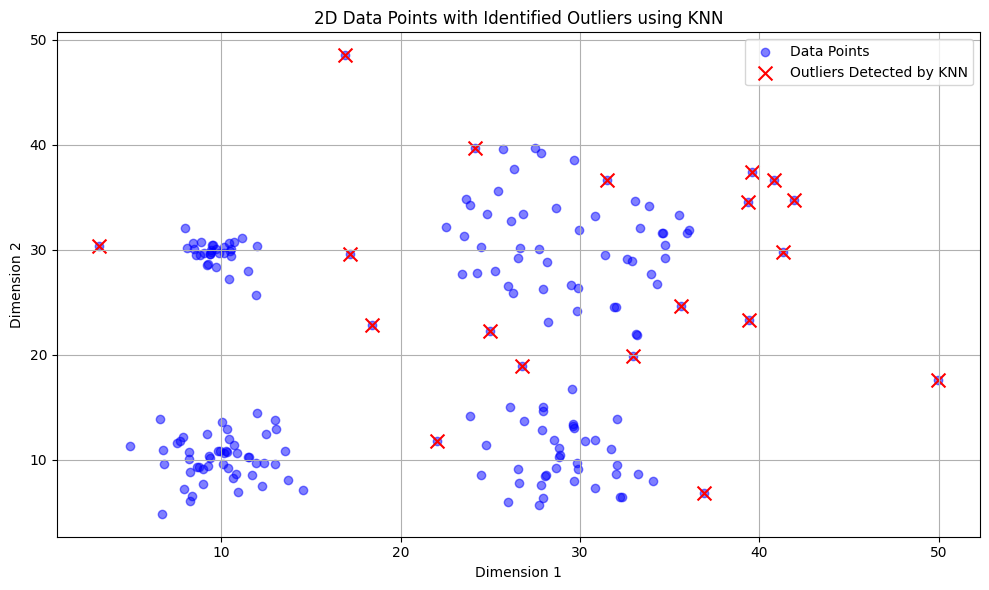

In [33]:
# Plot Outliers Detected by Distance-Based Approach
# Outlier Detection
outliers_detected, is_outlier_mask, mean_distances, distance_threshold = detect_outliers_with_knn(data, n_neighbors=5, outlier_fraction=0.1)

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points', alpha=0.5)
plt.scatter(outliers_detected[:, 0], outliers_detected[:, 1], color='red', marker='x', s=100, label='Outliers Detected by KNN')
plt.title('2D Data Points with Identified Outliers using KNN')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4. Apply the LOF algorithm from sklearn to detect outliers for upper data. The parameters are free to set. Plot Outliers Detected by Local Outlier Factor (LOF).

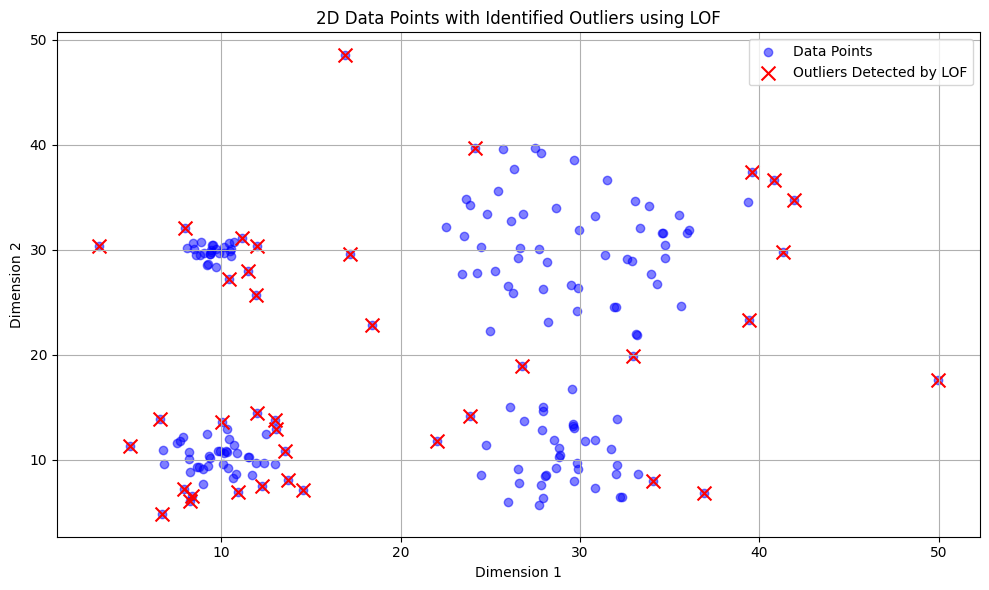

In [36]:
# Apply the LOF algorithm from sklearn to detect outliers for upper data. The parameters are free to set.
# Plot Outliers Detected by Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.2)
is_outlier = lof.fit_predict(data) == -1
outliers_detected = data[is_outlier]


plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points', alpha=0.5)
plt.scatter(outliers_detected[:, 0], outliers_detected[:, 1], color='red', marker='x', s=100, label='Outliers Detected by LOF')
plt.title('2D Data Points with Identified Outliers using LOF')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Imputation of Missing Values

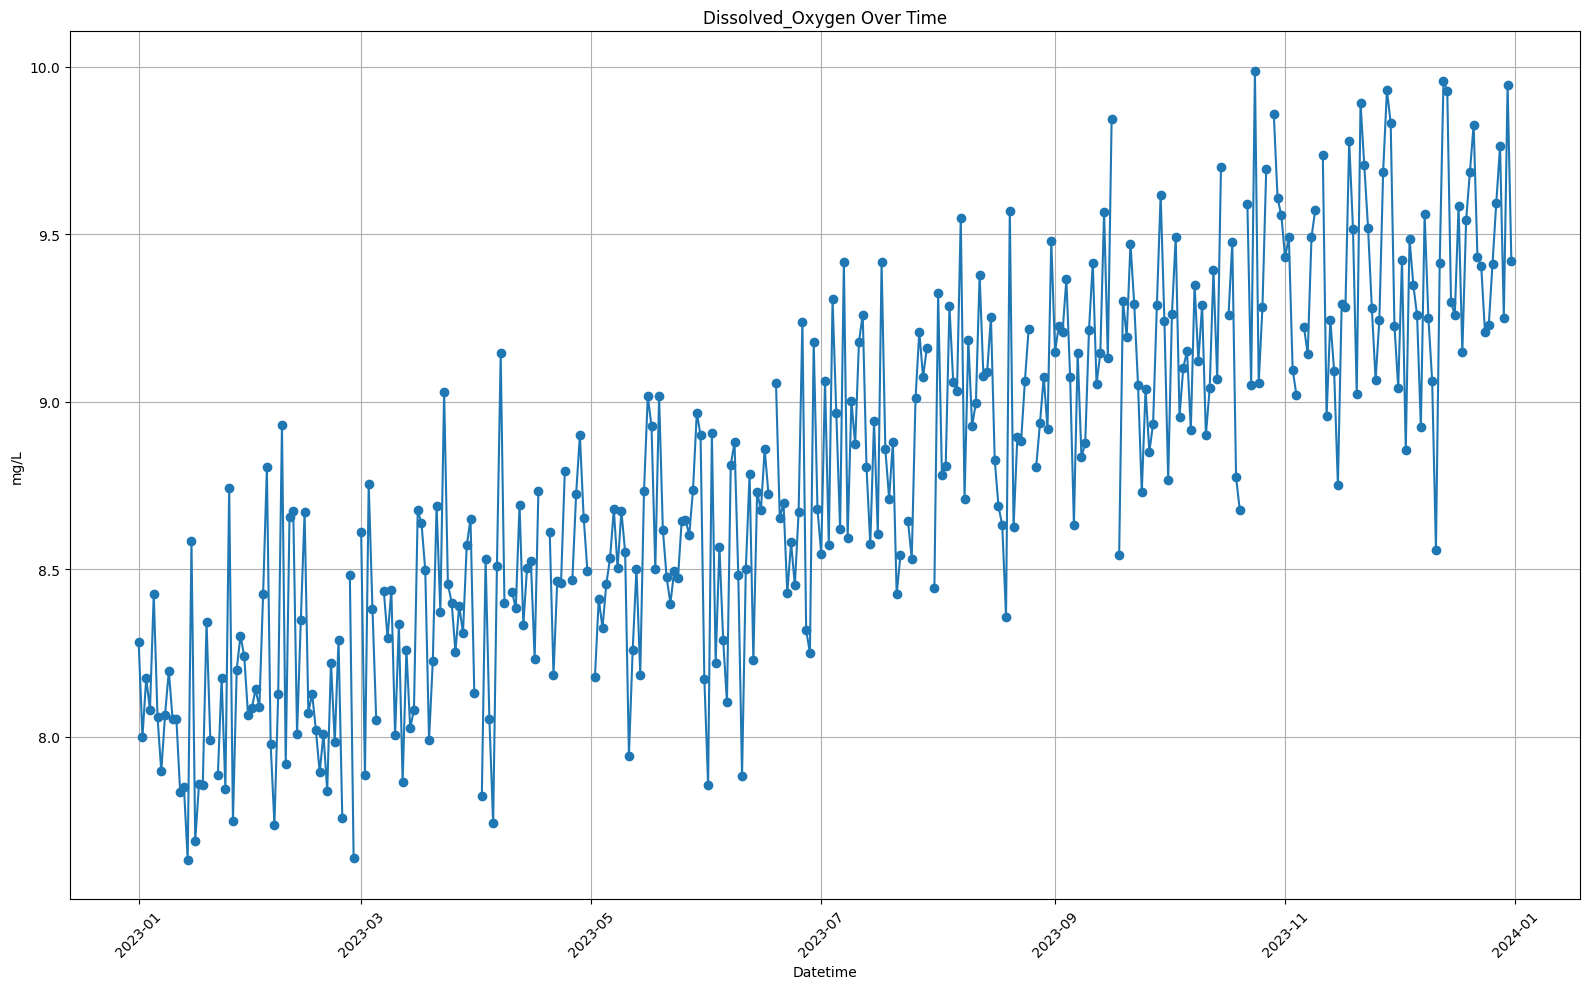

In [37]:
plt.figure(figsize=(16, 10))
plt.plot(dissolved_oxygen_data['Date'], dissolved_oxygen_data['Dissolved_Oxygen_mg_L'], marker='o', linestyle='-')
plt.title('Dissolved_Oxygen Over Time')
plt.xlabel('Datetime')
plt.ylabel('mg/L')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5. Replace missing values with the mean, mode, and median of the values. Then visualize the dataframe which have missing values and imputed values.

In [63]:
# Dissolved_Oxygen_mg_L하고 Date 열만 추출
Dissolved_Oxygen_data = DWLR_data[['Date', 'Dissolved_Oxygen_mg_L']].copy()
dissolved_oxygen_data = pd.DataFrame(dissolved_oxygen_data, columns=['Date', 'Dissolved_Oxygen_mg_L'])

Dissolved_Oxygen_data.head()

,Date,Dissolved_Oxygen_mg_L
0,2023-01-01,8.282231
1,2023-01-02,7.998230
2,2023-01-03,8.173989
3,2023-01-04,8.079537
4,2023-01-05,8.425726


In [69]:
# Replace missing values with the mean, mode, and median of the values.
dissolved_oxygen_values = dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].values

def mean_imputation(data):
    # Calculate the mean excluding NaN values
    mean_value = round(np.nanmean(data),0)
    # Replace NaN values with the mean
    mean_imputed_data = np.where(np.isnan(data), mean_value, data)
    return mean_imputed_data

def median_imputation(data):
    median_value = np.median(data[~np.isnan(data)])
    median_imputed_data = np.where(np.isnan(data), median_value, data)
    return median_imputed_data

def mode_imputation(data):
    data_no_nan = data[~np.isnan(data)]
    # Numpy has no direct method to calculate the mode
    values, counts = np.unique(data_no_nan, return_counts=True)
    mode_value = values[np.argmax(counts)]

    mode_imputed_data = np.where(np.isnan(data), mode_value, data)
    return mode_imputed_data

mean_imputed_data = mean_imputation(dissolved_oxygen_values)
dissolved_oxygen_data['mean_imputed'] = mean_imputed_data

median_imputed_data = median_imputation(dissolved_oxygen_values)
dissolved_oxygen_data['median_imputed'] = median_imputed_data

mode_imputed_data = mode_imputation(dissolved_oxygen_values)
dissolved_oxygen_data['mode_imputed'] = mode_imputed_data
dissolved_oxygen_data.head()


,Date,Dissolved_Oxygen_mg_L,mean_imputed,median_imputed,mode_imputed
0,2023-01-01,8.282231,8.282231,8.282231,8.282231
1,2023-01-02,7.998230,7.998230,7.998230,7.998230
2,2023-01-03,8.173989,8.173989,8.173989,8.173989
3,2023-01-04,8.079537,8.079537,8.079537,8.079537
4,2023-01-05,8.425726,8.425726,8.425726,8.425726


In [70]:
# Visualize the dataframe which have missing values and imputed values
nan_rows = dissolved_oxygen_data[dissolved_oxygen_data['Dissolved_Oxygen_mg_L'].isnull()]
nan_rows

,Date,Dissolved_Oxygen_mg_L,mean_imputed,median_imputed,mode_imputed
20,2023-01-21,NaN,9.0,8.750479,7.63279
55,2023-02-25,NaN,9.0,8.750479,7.63279
58,2023-02-28,NaN,9.0,8.750479,7.63279
64,2023-03-06,NaN,9.0,8.750479,7.63279
90,2023-04-01,NaN,9.0,8.750479,7.63279
98,2023-04-09,NaN,9.0,8.750479,7.63279
107,2023-04-18,NaN,9.0,8.750479,7.63279
108,2023-04-19,NaN,9.0,8.750479,7.63279
114,2023-04-25,NaN,9.0,8.750479,7.63279
120,2023-05-01,NaN,9.0,8.750479,7.63279
